# Leitura dos dados

In [1]:
from json import dump as json_dump, load as json_load, dumps
import os
import requests
import math
from tqdm import tqdm, trange
from time import sleep
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Biblioteca que permite plots mais robustos que o plt
from scipy import stats

np.random.seed(42)

In [2]:
!curl -L -o dataset.csv https://github.com/bgvinicius/fortaleza-rents-dataset/raw/master/full_rents.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3970k  100 3970k    0     0  2556k      0  0:00:01  0:00:01 --:--:-- 2556k


In [3]:
df = pd.read_csv("dataset.csv")
df.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)
df.head()

,amenities,usableAreas,description,title,unitTypes,parkingSpaces,suites,bathrooms,usageTypes,bedrooms,neighborhood,lat,lon,condoFee,rentPrice,iptu
0,"['ELEVATOR', 'GATED_COMMUNITY', 'GARDEN', 'PLA...",70.0,IMÓVEL IMPECÁVEL! L I N D A V I S T A M A R! <...,Apartamento para aluguel tem 70 metros quadrad...,APARTMENT,2.0,2.0,2.0,RESIDENTIAL,2.0,Meireles,-3.727880,-38.495875,730,2700,110
1,"['FURNISHED', 'BARBECUE_GRILL', 'ELEVATOR', 'G...",60.0,"Apartamento Duplex 60 m2, com 02 suítes, total...","Apartamento DUPLEX MOBILIADO, 02 suítes, em Me...",APARTMENT,1.0,2.0,2.0,RESIDENTIAL,2.0,Meireles,-3.727192,-38.490351,800,2500,200
2,"['AIR_CONDITIONING', 'PORCELAIN']",35.0,ANDAR ALTO;<br>PISO EM PORCELANATO;<br>ILUMINA...,"Sala comercial, localização INENARRÁVEL / para...",OFFICE,0.0,0.0,0.0,COMMERCIAL,0.0,Meireles,-3.736109,-38.490084,575,2500,330
3,[],33.0,"Salas com piso em porcelanato bianco, com forr...",Scopa Platinum Corporate - Salas amplas com WC,OFFICE,1.0,0.0,0.0,COMMERCIAL,0.0,Aldeota,-3.733264,-38.509330,428,1750,1143
4,[],30.0,COMPSA – COMPARTILHAMENTO DE SALAS: <br>I. MOB...,"COMPSA - Compartilhamento de Salas - Hora, Exp...",OFFICE,0.0,0.0,0.0,COMMERCIAL,0.0,Aldeota,-3.743591,-38.493051,0,500,0


In [4]:
df.describe()

,usableAreas,parkingSpaces,suites,bathrooms,bedrooms,lat,lon,condoFee,rentPrice,iptu
count,7492.000000,7492.000000,7492.000000,7492.000000,7492.000000,7492.000000,7492.000000,7.492000e+03,7492.000000,7492.000000
mean,302.293647,1.251468,0.506674,0.506674,1.310198,-3.744905,-38.519024,4.309800e+02,4145.321410,541.140416
std,1354.555366,10.053098,1.209950,1.209950,1.982876,0.027345,0.025670,1.560991e+04,17299.313716,10470.449313
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.902040,-38.630560,0.000000e+00,99.000000,0.000000
25%,37.000000,0.000000,0.000000,0.000000,0.000000,-3.747911,-38.525388,0.000000e+00,750.000000,0.000000
50%,63.000000,0.000000,0.000000,0.000000,1.000000,-3.730451,-38.521799,0.000000e+00,1300.000000,0.000000
75%,147.000000,1.000000,1.000000,1.000000,2.000000,-3.730451,-38.503734,3.200000e+02,3000.000000,70.250000
max,70526.000000,800.000000,42.000000,42.000000,70.000000,-3.703690,-38.389427,1.350000e+06,699000.000000,571362.000000


# Removendo parte dos outliers dos dados

Conforme observado na [análise exploratória dos dados](https://colab.research.google.com/drive/1O1QbzepzHHZdEs7J2MgnBtL3QpqoubFG#scrollTo=PFs74Ubq83Pz), o nosso dataset possui uma variação significativa dos dados após o percentil 75, por exemplo, observe o percentil 75 do atributo rentPrice, que está em R\$ 3000, enquanto o valor máximo observado para este atributo é R\$ 699000, muito além! Por essa razão, filtraremos os dados pela coluna rentPrice, considerando alugueis até R\$ 6000, que é duas vezes o percentil 75 para este atributo.

In [5]:
df = df[df['rentPrice'] <= 6000]

<AxesSubplot:>

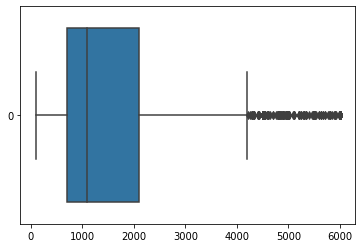

In [6]:
sns.boxplot(data=df['rentPrice'], orient="h")

Agora, os dados estão melhor 'distribuídos', não existem mais tantos outliers. 

In [7]:
df.describe()

,usableAreas,parkingSpaces,suites,bathrooms,bedrooms,lat,lon,condoFee,rentPrice,iptu
count,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000,6592.000000
mean,128.619235,0.964502,0.492263,0.492263,1.303853,-3.744834,-38.519585,225.992870,1644.796875,246.062197
std,356.607658,10.054937,1.016896,1.016896,1.418947,0.027232,0.025726,462.150011,1353.188925,5713.716775
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.902040,-38.630560,0.000000,99.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,-3.747824,-38.525880,0.000000,700.000000,0.000000
50%,56.000000,0.000000,0.000000,0.000000,1.000000,-3.730451,-38.521799,0.000000,1100.000000,0.000000
75%,100.000000,1.000000,1.000000,1.000000,2.000000,-3.730451,-38.504929,350.000000,2100.000000,70.000000
max,12352.000000,800.000000,36.000000,36.000000,17.000000,-3.704008,-38.389427,12434.000000,6000.000000,326275.000000


Entretanto, na coluna 'IPTU' e 'usableAreas' ainda temos valores bem fora da linha do percentil 75, portanto, limitaremos também os valores nesses atributos.

In [8]:
df = df[df["iptu"] <= 1000]
df = df[df["usableAreas"] <= 1000]

In [9]:
df.describe()

,usableAreas,parkingSpaces,suites,bathrooms,bedrooms,lat,lon,condoFee,rentPrice,iptu
count,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000
mean,92.632950,0.936401,0.482422,0.482422,1.299457,-3.744601,-38.519779,221.469958,1563.124161,61.581655
std,122.585994,10.295278,1.004431,1.004431,1.382256,0.026932,0.025752,453.014182,1291.253194,149.217492
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.902040,-38.630560,0.000000,99.000000,0.000000
25%,34.000000,0.000000,0.000000,0.000000,0.000000,-3.747672,-38.526109,0.000000,700.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,1.000000,-3.730451,-38.521799,0.000000,1050.000000,0.000000
75%,90.000000,1.000000,1.000000,1.000000,2.000000,-3.730451,-38.505369,350.000000,2000.000000,61.000000
max,1000.000000,800.000000,36.000000,36.000000,17.000000,-3.704008,-38.389427,12434.000000,6000.000000,1000.000000


Aqui, não vamos utilizar as colunas title e description no treinamento do nosso modelo, por serem apenas colunas descrevendo uma instância específica do dataset, portanto, removemos essas colunas.

In [10]:
df = df.drop(columns = ['description', 'title'])

# Transformação dos dados para treinamento

Os modelos em geral trabalham bem com números, mas temos algumas colunas que ainda não estão em formato apropriado

- amenities, uma lista de strings
- unitTypes, string
- usageTypes, string
- neighborhood, string

A coluna de amenities, iremos tratar diretamente usando o pandas, já a coluna unitTypes, usageTypes e neighborhood iremos usar o **One Hot Encoder** do pandas, comumente usado para transformar atributos categóricos em números. Para cada valor possível da nossa coluna categórica, será criada uma coluna nova para cada valor possível do atributo original, de modo que cada linha do conjunto de dados terá valor 1 apenas na coluna que seja correspondente ao valor do atributo no dado original, e 0 nas demais colunas.

<img src='https://e6v4p8w2.rocketcdn.me/wp-content/uploads/2022/01/One-Hot-Encoding-for-Scikit-Learn-in-Python-Explained-1536x864.png'> 

In [11]:
df.describe(include=['O'])

,amenities,unitTypes,usageTypes,neighborhood
count,6258,6258,6258,6257
unique,1378,17,2,129
top,[],APARTMENT,RESIDENTIAL,Centro
freq,3204,2526,3557,979


In [12]:
from ast import literal_eval

df['amenities'] = df['amenities'].apply(literal_eval)

In [13]:
df['amenities'].explode().describe()

count       13513
unique        156
top       KITCHEN
freq         1531
Name: amenities, dtype: object

In [14]:
df_amenities_expanded = df.join(df['amenities'].str.join('|').str.get_dummies().add_prefix('amenities_')
).drop(columns=['amenities'])

In [15]:
df_amenities_expanded

,usableAreas,unitTypes,parkingSpaces,suites,bathrooms,usageTypes,bedrooms,neighborhood,lat,lon,...,amenities_TREE_CLIMBING,amenities_TRUCK_ENTRANCE,amenities_VEGETABLE_GARDEN,amenities_WALLS_GRIDS,amenities_WALL_BALCONY,amenities_WATCHMAN,amenities_WELL,amenities_WHIRLPOOL,amenities_YOUTH_GAME_ROOM,amenities_ZEN_SPACE
0,70.0,APARTMENT,2.0,2.0,2.0,RESIDENTIAL,2.0,Meireles,-3.727880,-38.495875,...,0,0,0,0,0,0,0,0,0,0
1,60.0,APARTMENT,1.0,2.0,2.0,RESIDENTIAL,2.0,Meireles,-3.727192,-38.490351,...,0,0,0,0,0,0,0,0,0,0
2,35.0,OFFICE,0.0,0.0,0.0,COMMERCIAL,0.0,Meireles,-3.736109,-38.490084,...,0,0,0,0,0,0,0,0,0,0
4,30.0,OFFICE,0.0,0.0,0.0,COMMERCIAL,0.0,Aldeota,-3.743591,-38.493051,...,0,0,0,0,0,0,0,0,0,0
5,15.0,OFFICE,0.0,0.0,0.0,COMMERCIAL,0.0,José Bonifácio,-3.743001,-38.528323,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7486,15.0,OFFICE,0.0,0.0,0.0,COMMERCIAL,0.0,Mondubim,-3.730451,-38.521799,...,0,0,0,0,0,0,0,0,0,0
7487,594.0,HOME,12.0,2.0,2.0,RESIDENTIAL,5.0,Vila Velha,-3.722138,-38.595065,...,0,0,0,0,0,0,0,0,0,0
7488,297.0,BUSINESS,0.0,0.0,0.0,COMMERCIAL,0.0,Parque Santa Maria,-3.730451,-38.521799,...,0,0,0,0,0,0,0,0,0,0
7490,54.0,APARTMENT,2.0,1.0,1.0,RESIDENTIAL,2.0,Planalto Ayrton Senna,-3.833893,-38.567802,...,0,0,0,0,0,0,0,0,0,0


# Treinamento dos modelos

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Separação dos dados entre treino e teste, para geração e avaliação do modelo, usamos apenas os dados relativos a casas para moradia, deixando de lado os imóveis comerciais. 



In [17]:
training_df = df_amenities_expanded[df_amenities_expanded['usageTypes'] == 'RESIDENTIAL']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(training_df.drop(columns=['rentPrice', 'lat', 'lon']), training_df['rentPrice'])

Abaixo, montamos nossos pipelines de pre processamentos. Usamos KFold com 3 folds (como não temos muitos dados, usamos apeans 3 folds), além de uma grid search para otimização dos hiper parametros de cada modelo.

In [19]:
def get_scaled_pipeline():
  numeric_pipeline = Pipeline([('scale', RobustScaler())])
  label_pipeline = Pipeline([('encode', OneHotEncoder(handle_unknown='ignore'))])

  return ColumnTransformer([
    # ('label_transformer', label_pipeline, ['unitTypes', 'usageTypes']),
    ('label_transformer', label_pipeline, ['unitTypes', 'usageTypes', 'neighborhood']),
    ('numeric_transformer', numeric_pipeline, ['usableAreas', 'parkingSpaces', 'bathrooms', 'bedrooms', 'condoFee', 'iptu'])
  ], remainder='passthrough')

def get_default_pipeline():
  label_pipeline = Pipeline([('encode', OneHotEncoder(handle_unknown='ignore'))])

  return ColumnTransformer([
    ('label_transformer', label_pipeline, ['unitTypes', 'usageTypes', 'neighborhood'])
    # ('label_transformer', label_pipeline, ['unitTypes', 'usageTypes'])
  ], remainder='passthrough')


def train_linear_regression(X_train, y_train):
  kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

  model = Pipeline([
    ('transform', get_scaled_pipeline()),
    ('model', LinearRegression())
  ])

  grid = GridSearchCV(scoring='neg_root_mean_squared_error', estimator=model, param_grid = {}, cv=kfold_cv)
  grid.fit(X_train, y_train)
  return grid


def train_knn(X_train, y_train):
  kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

  knn_hiperparameters = {
    'model__n_neighbors': range(5, 51, 5), 
    'model__weights': ['uniform', 'distance'], 
    'model__metric': ["euclidean", "manhattan", "chebyshev"]
  }

  model = Pipeline([
    ('transform', get_default_pipeline()),
    ('model', KNeighborsRegressor())
  ])

  grid = GridSearchCV(scoring='neg_root_mean_squared_error', estimator=model, param_grid = knn_hiperparameters, cv=kfold_cv)
  grid.fit(X_train, y_train)
  return grid

def train_decision_tree(X_train, y_train):
  dt_hiperparameters = {
    'model__criterion': ['squared_error', 'absolute_error', 'poisson'],
    'model__splitter': ['best', 'random']
  }

  kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

  model = Pipeline([
    ('transform', get_default_pipeline()),
    ('model', DecisionTreeRegressor())
  ])

  grid = GridSearchCV(scoring='neg_root_mean_squared_error', estimator=model, param_grid = dt_hiperparameters, cv=kfold_cv)
  grid.fit(X_train, y_train)
  return grid


def train_random_forest(X_train, y_train):
  rf_hiperparameters = {
    'model__criterion': ['absolute_error'],
    'model__n_estimators': [100],
    'model__max_features': ['sqrt', 0.25, 1.0, 0.5],
    'model__max_depth': [None]
  }
  kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

  model = Pipeline([
    ('transform', get_default_pipeline()),
    ('model', RandomForestRegressor(n_jobs = 6))
  ])

  grid = GridSearchCV(scoring='neg_root_mean_squared_error', estimator=model, param_grid = rf_hiperparameters, cv=kfold_cv, verbose=1)
  grid.fit(X_train, y_train)
  return grid

def train_svr(X_train, y_train):
  kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)
  svr_hiperparameters = {
    'model__kernel': ['rbf'], 
    'model__gamma': ['scale'], 
    'model__C': [3000, 4000, 4500, 5000],
    'model__epsilon': [0.1, 0.75]
  }

  model = Pipeline([
    ('transform', get_scaled_pipeline()),
    ('model', SVR())
  ])

  grid = GridSearchCV(scoring='neg_root_mean_squared_error', estimator=model, param_grid = svr_hiperparameters, cv=kfold_cv)
  grid.fit(X_train, y_train)
  return grid

def get_grid_results(grid):
  return pd.DataFrame(grid.cv_results_).sort_values(by=f"rank_test_score", ascending=True)


Abaixo, faremos o treino de cada modelo, obtendo os hiperparametros ideais e realizando um novo fit utilizando estes hiperparametros obtidos.

In [20]:
linear_reg_grid = train_linear_regression(X_train, y_train)

In [21]:
knn_grid = train_knn(X_train, y_train)

In [22]:
decision_tree_grid = train_decision_tree(X_train, y_train)

In [23]:
svr_grid = train_svr(X_train, y_train)

In [24]:
random_forest_grid = train_random_forest(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [25]:
get_grid_results(linear_reg_grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.109121,0.040601,0.011114,0.002947,{},-2.259938e+12,-3.734591e+13,-5.513245e+12,-1.503970e+13,1.582869e+13,1


In [26]:
get_grid_results(knn_grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
25,0.009492,0.000619,0.058392,0.002780,manhattan,15,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-833.034921,-674.118504,-741.067985,-749.407137,65.144777,1
23,0.009320,0.000234,0.056205,0.000232,manhattan,10,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-830.354143,-678.740667,-746.690910,-751.928573,62.006647,2
27,0.009570,0.000094,0.061363,0.003784,manhattan,20,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-833.129136,-680.439457,-742.344224,-751.970939,62.705873,3
29,0.009510,0.000160,0.062030,0.004494,manhattan,25,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-831.555383,-687.156591,-743.056884,-753.922953,59.449174,4
31,0.010311,0.001089,0.059016,0.000711,manhattan,30,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-831.523755,-686.590677,-746.123057,-754.745830,59.482006,5
33,0.009477,0.000320,0.059358,0.001530,manhattan,35,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-834.504443,-689.556810,-751.978779,-758.680011,59.364041,6
35,0.009374,0.000074,0.058204,0.000723,manhattan,40,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-835.522696,-689.967797,-755.675927,-760.388807,59.515912,7
37,0.009219,0.000127,0.063008,0.006612,manhattan,45,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-837.013706,-689.577154,-758.881524,-761.824128,60.226674,8
39,0.009749,0.000483,0.058782,0.000150,manhattan,50,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-836.470253,-692.301607,-762.207683,-763.659848,58.865560,9
21,0.009213,0.000074,0.057466,0.001422,manhattan,5,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",-847.642774,-692.402535,-765.843172,-768.629493,63.407179,10


In [27]:
get_grid_results(decision_tree_grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.032906,0.000373,0.007164,0.001795,squared_error,random,"{'model__criterion': 'squared_error', 'model__...",-834.673315,-817.636696,-849.970958,-834.093656,13.206769,1
4,0.037643,0.000624,0.007813,0.001804,poisson,best,"{'model__criterion': 'poisson', 'model__splitt...",-841.787821,-877.470037,-796.095131,-838.450997,33.304851,2
0,0.037085,0.002169,0.006181,0.000625,squared_error,best,"{'model__criterion': 'squared_error', 'model__...",-867.020925,-874.537387,-810.186543,-850.581618,28.727987,3
5,0.035629,0.002382,0.006777,0.000582,poisson,random,"{'model__criterion': 'poisson', 'model__splitt...",-870.917596,-871.187713,-841.657291,-861.254200,13.857546,4
2,0.692898,0.040119,0.006347,0.002421,absolute_error,best,"{'model__criterion': 'absolute_error', 'model_...",-940.768631,-849.632506,-855.846934,-882.082690,41.574708,5
3,0.823903,0.060167,0.008454,0.001599,absolute_error,random,"{'model__criterion': 'absolute_error', 'model_...",-934.489727,-938.789372,-863.878895,-912.385998,34.344587,6


In [28]:
get_grid_results(random_forest_grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__max_features,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,2.140115,0.016798,0.031447,0.003593,absolute_error,None,0.25,100,"{'model__criterion': 'absolute_error', 'model_...",-660.303811,-600.647894,-621.959403,-627.637036,24.683108,1
3,3.913555,0.130510,0.033514,0.000546,absolute_error,None,0.5,100,"{'model__criterion': 'absolute_error', 'model_...",-669.954815,-595.071179,-622.280185,-629.102060,30.949348,2
2,7.364128,0.338277,0.031892,0.002146,absolute_error,None,1.0,100,"{'model__criterion': 'absolute_error', 'model_...",-665.986988,-594.510351,-628.294365,-629.597235,29.194755,3
0,1.245589,0.318659,0.035989,0.004610,absolute_error,None,sqrt,100,"{'model__criterion': 'absolute_error', 'model_...",-662.566288,-610.072390,-660.476344,-644.371674,24.268259,4


In [29]:
get_grid_results(svr_grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__epsilon,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.815112,0.020315,0.361127,0.017066,3000,0.75,scale,rbf,"{'model__C': 3000, 'model__epsilon': 0.75, 'mo...",-673.641812,-622.731249,-658.338351,-651.570471,21.327986,1
0,1.247929,0.120831,0.478607,0.083945,3000,0.1,scale,rbf,"{'model__C': 3000, 'model__epsilon': 0.1, 'mod...",-673.684066,-622.777798,-658.382025,-651.614630,21.326201,2
3,1.103254,0.042610,0.420594,0.039262,4000,0.75,scale,rbf,"{'model__C': 4000, 'model__epsilon': 0.75, 'mo...",-673.180316,-627.204253,-659.197044,-653.193871,19.243669,3
2,0.983811,0.093547,0.416780,0.051503,4000,0.1,scale,rbf,"{'model__C': 4000, 'model__epsilon': 0.1, 'mod...",-673.221794,-627.269563,-659.218649,-653.236668,19.230877,4
5,0.922418,0.009141,0.388984,0.016124,4500,0.75,scale,rbf,"{'model__C': 4500, 'model__epsilon': 0.75, 'mo...",-673.501409,-629.191821,-659.744083,-654.145771,18.517392,5
4,1.013054,0.100965,0.390118,0.033843,4500,0.1,scale,rbf,"{'model__C': 4500, 'model__epsilon': 0.1, 'mod...",-673.543336,-629.267381,-659.751703,-654.187473,18.498838,6
7,1.009001,0.082138,0.381070,0.038359,5000,0.75,scale,rbf,"{'model__C': 5000, 'model__epsilon': 0.75, 'mo...",-674.282590,-630.967893,-660.033090,-655.094524,18.024665,7
6,1.053377,0.110913,0.410063,0.040946,5000,0.1,scale,rbf,"{'model__C': 5000, 'model__epsilon': 0.1, 'mod...",-674.324416,-631.025016,-660.057089,-655.135507,18.016214,8


# Avaliação dos modelos

Por fim, avaliaremos os modelos. Na gridsearch, utilizamos como métrica o RMSE, pois para o nosso problema, o ideal é que os erros sejam os menores possíveis, e que também não existam muitos erros extremos, algo que é coberto pela RMSE.

Para avaliação dos modelos, consideramos as seguintes métricas:

- RMSE
- MAE
- R2
- MSE

In [30]:
models = {
    "linear_regression": linear_reg_grid,
    "knn": knn_grid,
    "decision_tree": decision_tree_grid,
    "svr": svr_grid,
    "random_forest": random_forest_grid
}

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def rmse(actual, predicted):
  return mean_squared_error(actual, predicted, squared=False)


In [32]:
def compute_errors(X_test, y_test, models, error_metric_fn):
  return { model_name: error_metric_fn(y_test, model.predict(X_test)) for model_name, model in models.items() }

def plot_error_by_model(X_test, y_test, models, error_metric_fn, max_range, use_max=False):
  errors = compute_errors(X_test, y_test, models, error_metric_fn)
  X_values = list(errors.keys())
  rounder = max if use_max else min
  Y_values = list(map(lambda l: rounder(max_range, l), errors.values()))

  sns.barplot(x=X_values, y=Y_values)

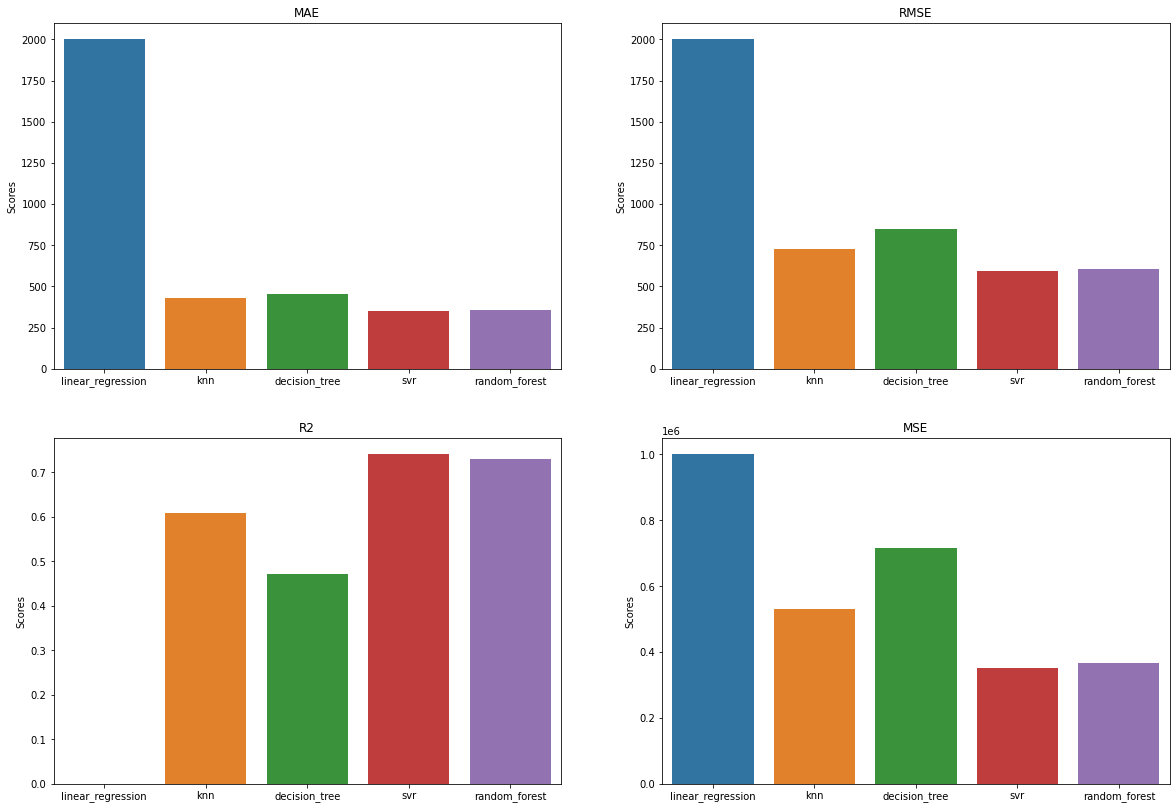

In [33]:
f = plt.figure(figsize=(20, 14))
gs = f.add_gridspec(2, 2)


f.add_subplot(gs[0, 0])

plot_error_by_model(X_test, y_test, models, mean_absolute_error, 2000)
plt.title("MAE")
plt.ylabel('Scores')

f.add_subplot(gs[0, 1])

plot_error_by_model(X_test, y_test, models, rmse, 2000)
plt.title("RMSE")
plt.ylabel('Scores')

f.add_subplot(gs[1, 0])

plot_error_by_model(X_test, y_test, models, r2_score, 0, use_max=True)
plt.title("R2")
plt.ylabel('Scores')

f.add_subplot(gs[1, 1])

plot_error_by_model(X_test, y_test, models, mean_squared_error, 10 ** 6)
plt.title("MSE")
_ = plt.ylabel('Scores')



Como podemos ver, o modelo utilizando RandomForest foi o melhor em todas as métricas! 

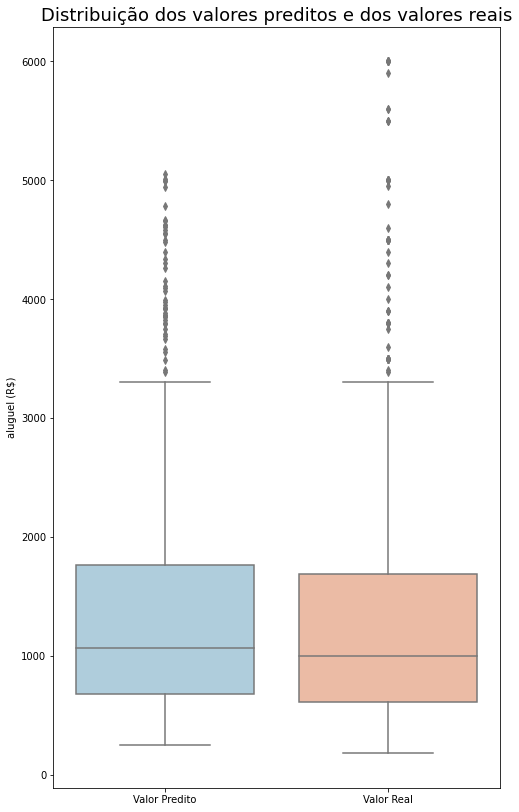

In [34]:
y_pred = random_forest_grid.predict(X_test)

plot_data = pd.DataFrame([(predict, "Valor Predito") for predict in y_pred] + [(real_value, "Valor Real") for real_value in y_test], columns=["aluguel (R$)", ""])

plt.figure(figsize=(8, 14))
plt.title('Distribuição dos valores preditos e dos valores reais', fontsize=18)
sns.boxplot(x="", y="aluguel (R$)", data=plot_data, palette='RdBu_r');

In [35]:
print(f"MAE do SVR: {mean_absolute_error(y_test, svr_grid.predict(X_test))}" )
print(f"RMSE da SVR: {rmse(y_test, svr_grid.predict(X_test))}" )

MAE do SVR: 350.0827633212102
RMSE da SVR: 593.4306187722775


In [36]:
print(f"MAE da RandomForest: {mean_absolute_error(y_test, random_forest_grid.predict(X_test))}" )
print(f"RMSE da RandomForest: {rmse(y_test, random_forest_grid.predict(X_test))}" )

MAE da RandomForest: 355.60458426966295
RMSE da RandomForest: 605.7522363522784


Algumas conclusões:

- Para uma primeira iteração, o algoritmo RandomForest foi muito interessante, além do SVR, pois ambos estão bem próximos em termos de precisão
- Pode ser interessante experimentar alterando mais parâmetros da RandomForest, possivelmente encontrando combinações ainda melhores
- Mesmo limpando parte dos outliers, o dataset ainda tem alguns problemas relativos a qualidade dos dados. Isso pode ser melhorado, o que pode levar a novos modelos ainda melhores!
- O dataset possui dados de diferentes bairros, além de que os imóveis podem ser casas e apartamentos. O balanceamento desses dados deve ser levado em consideração na hora de realizar a separação dos dados para treino/teste/validação (folds). 